In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from numpy.random import randn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as td
import matplotlib.pyplot as plt
import matplotlib
from collections import OrderedDict
import torch.utils.data as data

import datasets as D

import tqdm
from scipy.stats import gaussian_kde

In [28]:
sn = nn.utils.spectral_norm

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            sn(nn.Linear(2, 100)),
            nn.LeakyReLU(),
            sn(nn.Linear(100, 100)),
            nn.LeakyReLU(),
            nn.Linear(100, 1)
        )
    
    def forward(self, x):
        return self.net.forward(x)

In [3]:
def hinge_dis(dis_fake, dis_real):
    loss_real = torch.mean(F.relu(1. - dis_real))
    loss_fake = torch.mean(F.relu(1. + dis_fake))
    return loss_real, loss_fake

def kl_dis(dis_fake, dis_real):
    return torch.mean(dis_real) - torch.mean(torch.exp(dis_fake - 1.0))

def klw_dis(dis_fake, dis_real):
    dis_fake_norm = torch.exp(dis_fake).mean()
    with torch.no_grad():
        dis_fake_ratio = torch.exp(dis_fake) / dis_fake_norm
    eval_loss = torch.mean(dis_real)- torch.mean(dis_fake_ratio * dis_fake) # + torch.mean(torch.log(dis_fake_ratio) * dis_fake_ratio) 
#     train_loss = torch.mean(dis_real) - torch.mean(dis_rake_ratio * dis_fake)
    
    return eval_loss

In [188]:
P = D.Ring()
real_samples = P.sample(1000)
real_loader = data.DataLoader(data.TensorDataset(
    torch.from_numpy(real_samples).float()), batch_size=512)

Q = D.Uniform()
fake_samples = Q.sample(5000)[-1000:]
fake_loader = data.DataLoader(data.TensorDataset(
    torch.from_numpy(fake_samples).float()), batch_size=512)

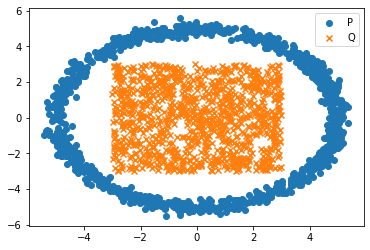

In [189]:
plt.scatter(real_samples[:, 0], real_samples[:, 1], label='P')
plt.scatter(fake_samples[:, 0], fake_samples[:, 1], marker='x', label='Q')
plt.legend()

In [4]:
def train_dr_estimator(loss_type='kl', epochs=200):
    d_net = Discriminator().to('cuda')
    d_optim = optim.RMSprop(d_net.parameters(), lr=0.0002)
    for e in range(epochs):
        for real, fake in zip(real_loader, fake_loader):
            real, fake = real[0].to('cuda'), fake[0].to('cuda')
            dis_real = d_net(real)
            dis_fake = d_net(fake)
            
            if loss_type == 'kl':
                loss = -kl_dis(dis_fake, dis_real)
            elif loss_type == 'kl_w':
                loss = -klw_dis(dis_fake, dis_real)
            loss.backward()
            d_optim.step()
    return d_net
#         if e % 50 == 0:
#             print(dis_real.mean().item(), dis_fake.mean().item())
#             print((torch.exp(dis_real).mean() / torch.exp(dis_fake).mean()).item(), (torch.exp(dis_fake).mean() / torch.exp(dis_fake).mean()).item())
#         # print(torch.exp(dis_real - 1.0).mean().item(), torch.exp(dis_fake - 1.0).mean().item())

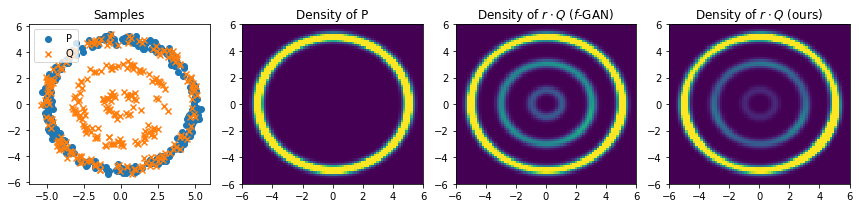

In [29]:
P = D.Ring()
real_samples = P.sample(1000)
real_loader = data.DataLoader(data.TensorDataset(
    torch.from_numpy(real_samples).float()), batch_size=512)

Q = D.Multiring()
fake_samples = Q.sample(5000)[-1000:]
fake_loader = data.DataLoader(data.TensorDataset(
    torch.from_numpy(fake_samples).float()), batch_size=512)

xmin, xmax = -6.0, 6.0
ymin, ymax = -6.0, 6.0
vmax = 0.035

fig = plt.figure(figsize=(12, 3))

ax = fig.add_subplot(1, 4, 1)
plt.scatter(real_samples[:300, 0], real_samples[:300, 1], label='P')
plt.scatter(fake_samples[:300, 0], fake_samples[:300, 1], marker='x', label='Q')
plt.legend()
plt.title('Samples')

ax = fig.add_subplot(1, 4, 2)

x, y = np.linspace(xmin, xmax, 75), np.linspace(ymin, ymax, 75)
xv, yv = np.meshgrid(x, y)
xt = np.concatenate([np.reshape(xv, [-1, 1]), np.reshape(yv, [-1, 1])], axis=1)
density = torch.from_numpy(P.logpdf_multiple(xt)).float().cuda().exp().view(-1, 1)
                           
xt = torch.from_numpy(xt).float().to('cuda')

with torch.no_grad():
    s = density.cpu().numpy().reshape([75, 75])
plt.pcolormesh(x, y, s, vmax=vmax)

plt.title('Density of P')

ax = fig.add_subplot(1, 4, 3)
d_net = train_dr_estimator(loss_type='kl')

dis_fake = d_net(torch.from_numpy(fake_samples).float().cuda()).exp().mean()

x, y = np.linspace(xmin, xmax, 75), np.linspace(ymin, ymax, 75)
xv, yv = np.meshgrid(x, y)
xt = np.concatenate([np.reshape(xv, [-1, 1]), np.reshape(yv, [-1, 1])], axis=1)
density = torch.from_numpy(Q.logpdf_multiple(xt)).float().cuda().exp().view(-1, 1)
                           
xt = torch.from_numpy(xt).float().to('cuda')

with torch.no_grad():
    s = (torch.exp(d_net(xt) - 1.0) * density).cpu().numpy().reshape([75, 75])
plt.pcolormesh(x, y, s, vmax=vmax)
plt.title(r'Density of $r \cdot Q$ ($f$-GAN)')

ax = fig.add_subplot(1, 4, 4)

d_net = train_dr_estimator(loss_type='kl_w')
dis_fake = d_net(torch.from_numpy(fake_samples).float().cuda()).exp().mean()

x, y = np.linspace(xmin, xmax, 75), np.linspace(ymin, ymax, 75)
xv, yv = np.meshgrid(x, y)
xt = np.concatenate([np.reshape(xv, [-1, 1]), np.reshape(yv, [-1, 1])], axis=1)
density = torch.from_numpy(Q.logpdf_multiple(xt)).float().cuda().exp().view(-1, 1)
                           
xt = torch.from_numpy(xt).float().to('cuda')

with torch.no_grad():
    s = (torch.exp(d_net(xt)) / dis_fake * density).cpu().numpy().reshape([75, 75])
plt.pcolormesh(x, y, s, vmax=vmax)
plt.title(r'Density of $r \cdot Q$ (ours)')

plt.tight_layout()
plt.savefig('r1.pdf', bbox_inches=None, dpi=30)

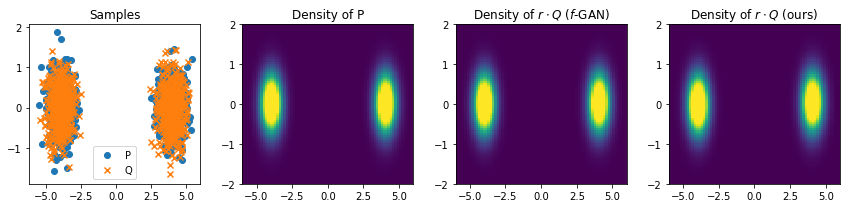

In [22]:
P = D.Grid()
real_samples = P.sample(1000)
real_loader = data.DataLoader(data.TensorDataset(
    torch.from_numpy(real_samples).float()), batch_size=512)

Q = D.Grid()
fake_samples = Q.sample(5000)[-1000:]
fake_loader = data.DataLoader(data.TensorDataset(
    torch.from_numpy(fake_samples).float()), batch_size=512)

xmin, xmax = -6.0, 6.0
ymin, ymax = -2.0, 2.0
vmax = 0.2

fig = plt.figure(figsize=(12, 3))

ax = fig.add_subplot(1, 4, 1)
plt.scatter(real_samples[:, 0], real_samples[:, 1], label='P')
plt.scatter(fake_samples[:, 0], fake_samples[:, 1], marker='x', label='Q')
plt.legend()
plt.title('Samples')

ax = fig.add_subplot(1, 4, 2)

x, y = np.linspace(xmin, xmax, 75), np.linspace(ymin, ymax, 75)
xv, yv = np.meshgrid(x, y)
xt = np.concatenate([np.reshape(xv, [-1, 1]), np.reshape(yv, [-1, 1])], axis=1)
density = torch.from_numpy(P.logpdf_multiple(xt)).float().cuda().exp().view(-1, 1)
                           
xt = torch.from_numpy(xt).float().to('cuda')

with torch.no_grad():
    s = density.cpu().numpy().reshape([75, 75])
plt.pcolormesh(x, y, s, vmax=vmax)

plt.title('Density of P')

ax = fig.add_subplot(1, 4, 3)
d_net = train_dr_estimator(loss_type='kl')

dis_fake = d_net(torch.from_numpy(fake_samples).float().cuda()).exp().mean()

x, y = np.linspace(xmin, xmax, 75), np.linspace(ymin, ymax, 75)
xv, yv = np.meshgrid(x, y)
xt = np.concatenate([np.reshape(xv, [-1, 1]), np.reshape(yv, [-1, 1])], axis=1)
density = torch.from_numpy(Q.logpdf_multiple(xt)).float().cuda().exp().view(-1, 1)
                           
xt = torch.from_numpy(xt).float().to('cuda')

with torch.no_grad():
    s = (torch.exp(d_net(xt) - 1.0) * density).cpu().numpy().reshape([75, 75])
plt.pcolormesh(x, y, s, vmax=vmax)
plt.title(r'Density of $r \cdot Q$ ($f$-GAN)')

ax = fig.add_subplot(1, 4, 4)

d_net = train_dr_estimator(loss_type='kl_w')
dis_fake = d_net(torch.from_numpy(fake_samples).float().cuda()).exp().mean()

x, y = np.linspace(xmin, xmax, 75), np.linspace(ymin, ymax, 75)
xv, yv = np.meshgrid(x, y)
xt = np.concatenate([np.reshape(xv, [-1, 1]), np.reshape(yv, [-1, 1])], axis=1)
density = torch.from_numpy(Q.logpdf_multiple(xt)).float().cuda().exp().view(-1, 1)
                           
xt = torch.from_numpy(xt).float().to('cuda')

with torch.no_grad():
    s = (torch.exp(d_net(xt)) / dis_fake * density).cpu().numpy().reshape([75, 75])
plt.pcolormesh(x, y, s, vmax=vmax)
plt.title(r'Density of $r \cdot Q$ (ours)')

plt.tight_layout()
plt.savefig('r2.pdf', bbox_inches=None, dpi=30)

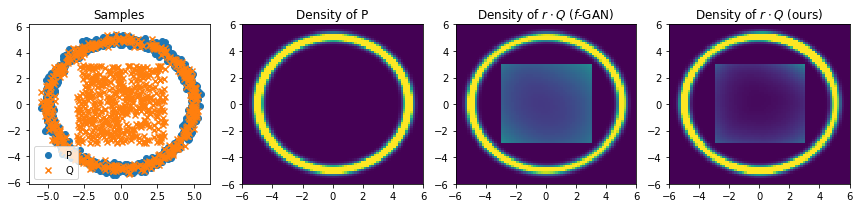

In [31]:
P = D.Ring()
real_samples = P.sample(1000)
real_loader = data.DataLoader(data.TensorDataset(
    torch.from_numpy(real_samples).float()), batch_size=512, shuffle=True)

Q = D.Uniform()
fake_samples = np.concatenate([Q.sample(5000)[-500:], P.sample(5000)[-500:]], axis=0)
fake_loader = data.DataLoader(data.TensorDataset(
    torch.from_numpy(fake_samples).float()), batch_size=512, shuffle=True)

xmin, xmax = -6.0, 6.0
ymin, ymax = -6.0, 6.0
vmax = 0.035

fig = plt.figure(figsize=(12, 3))

ax = fig.add_subplot(1, 4, 1)
plt.scatter(real_samples[:, 0], real_samples[:, 1], label='P')
plt.scatter(fake_samples[:, 0], fake_samples[:, 1], marker='x', label='Q')
plt.legend()
plt.title('Samples')

ax = fig.add_subplot(1, 4, 2)

x, y = np.linspace(xmin, xmax, 75), np.linspace(ymin, ymax, 75)
xv, yv = np.meshgrid(x, y)
xt = np.concatenate([np.reshape(xv, [-1, 1]), np.reshape(yv, [-1, 1])], axis=1)
density = torch.from_numpy(P.logpdf_multiple(xt)).float().cuda().exp().view(-1, 1)
                           
xt = torch.from_numpy(xt).float().to('cuda')

with torch.no_grad():
    s = density.cpu().numpy().reshape([75, 75])
plt.pcolormesh(x, y, s, vmax=vmax)

plt.title('Density of P')

ax = fig.add_subplot(1, 4, 3)
d_net = train_dr_estimator(loss_type='kl', epochs=100)

dis_fake = d_net(torch.from_numpy(fake_samples).float().cuda()).exp().mean()

x, y = np.linspace(xmin, xmax, 75), np.linspace(ymin, ymax, 75)
xv, yv = np.meshgrid(x, y)
xt = np.concatenate([np.reshape(xv, [-1, 1]), np.reshape(yv, [-1, 1])], axis=1)
density = 0.5 * (torch.from_numpy(P.logpdf_multiple(xt)).float().cuda().exp() + torch.from_numpy(Q.logpdf_multiple(xt)).float().cuda().exp()).view(-1, 1)
                           
xt = torch.from_numpy(xt).float().to('cuda')

with torch.no_grad():
    s = (torch.exp(d_net(xt) - 1.0) * density).cpu().numpy().reshape([75, 75])
plt.pcolormesh(x, y, s, vmax=vmax)
plt.title(r'Density of $r \cdot Q$ ($f$-GAN)')

ax = fig.add_subplot(1, 4, 4)

d_net = train_dr_estimator(loss_type='kl_w', epochs=200)
dis_fake = d_net(torch.from_numpy(fake_samples).float().cuda()).exp().mean()

x, y = np.linspace(xmin, xmax, 75), np.linspace(ymin, ymax, 75)
xv, yv = np.meshgrid(x, y)
xt = np.concatenate([np.reshape(xv, [-1, 1]), np.reshape(yv, [-1, 1])], axis=1)
density = 0.5 * (torch.from_numpy(P.logpdf_multiple(xt)).float().cuda().exp() + torch.from_numpy(Q.logpdf_multiple(xt)).float().cuda().exp()).view(-1, 1)
                           
xt = torch.from_numpy(xt).float().to('cuda')

with torch.no_grad():
    s = (torch.exp(d_net(xt)) / dis_fake * density).cpu().numpy().reshape([75, 75])
plt.pcolormesh(x, y, s, vmax=vmax)
plt.title(r'Density of $r \cdot Q$ (ours)')

plt.tight_layout()
plt.savefig('r3.pdf', bbox_inches=None)

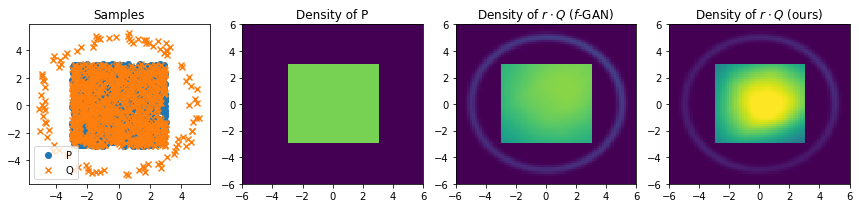

In [33]:
P = D.Uniform()
real_samples = P.sample(1000)
real_loader = data.DataLoader(data.TensorDataset(
    torch.from_numpy(real_samples).float()), batch_size=512, shuffle=True)

Q = D.Ring()
fake_samples = np.concatenate([Q.sample(5000)[-100:], P.sample(5000)[-900:]], axis=0)
fake_loader = data.DataLoader(data.TensorDataset(
    torch.from_numpy(fake_samples).float()), batch_size=512, shuffle=True)

xmin, xmax = -6.0, 6.0
ymin, ymax = -6.0, 6.0
vmax = 0.035

fig = plt.figure(figsize=(12, 3))

ax = fig.add_subplot(1, 4, 1)
plt.scatter(real_samples[:, 0], real_samples[:, 1], label='P')
plt.scatter(fake_samples[:, 0], fake_samples[:, 1], marker='x', label='Q')
plt.legend()
plt.title('Samples')

ax = fig.add_subplot(1, 4, 2)

x, y = np.linspace(xmin, xmax, 75), np.linspace(ymin, ymax, 75)
xv, yv = np.meshgrid(x, y)
xt = np.concatenate([np.reshape(xv, [-1, 1]), np.reshape(yv, [-1, 1])], axis=1)
density = torch.from_numpy(P.logpdf_multiple(xt)).float().cuda().exp().view(-1, 1)
                           
xt = torch.from_numpy(xt).float().to('cuda')

with torch.no_grad():
    s = density.cpu().numpy().reshape([75, 75])
plt.pcolormesh(x, y, s, vmax=vmax)

plt.title('Density of P')

ax = fig.add_subplot(1, 4, 3)
d_net = train_dr_estimator(loss_type='kl', epochs=100)

dis_fake = d_net(torch.from_numpy(fake_samples).float().cuda()).exp().mean()

x, y = np.linspace(xmin, xmax, 75), np.linspace(ymin, ymax, 75)
xv, yv = np.meshgrid(x, y)
xt = np.concatenate([np.reshape(xv, [-1, 1]), np.reshape(yv, [-1, 1])], axis=1)
density = (0.9 * torch.from_numpy(P.logpdf_multiple(xt)).float().cuda().exp() + 0.1 * torch.from_numpy(Q.logpdf_multiple(xt)).float().cuda().exp()).view(-1, 1)
                           
xt = torch.from_numpy(xt).float().to('cuda')

with torch.no_grad():
    s = (torch.exp(d_net(xt) - 1.0) * density).cpu().numpy().reshape([75, 75])
plt.pcolormesh(x, y, s, vmax=vmax)
plt.title(r'Density of $r \cdot Q$ ($f$-GAN)')

ax = fig.add_subplot(1, 4, 4)

d_net = train_dr_estimator(loss_type='kl_w', epochs=50)
dis_fake = d_net(torch.from_numpy(fake_samples).float().cuda()).exp().mean()

x, y = np.linspace(xmin, xmax, 75), np.linspace(ymin, ymax, 75)
xv, yv = np.meshgrid(x, y)
xt = np.concatenate([np.reshape(xv, [-1, 1]), np.reshape(yv, [-1, 1])], axis=1)
density = (0.9 * torch.from_numpy(P.logpdf_multiple(xt)).float().cuda().exp() + 0.1 * torch.from_numpy(Q.logpdf_multiple(xt)).float().cuda().exp()).view(-1, 1)
                           
xt = torch.from_numpy(xt).float().to('cuda')

with torch.no_grad():
    s = (torch.exp(d_net(xt)) / dis_fake * density).cpu().numpy().reshape([75, 75])
plt.pcolormesh(x, y, s, vmax=vmax)
plt.title(r'Density of $r \cdot Q$ (ours)')

plt.tight_layout()
plt.savefig('r4.pdf', bbox_inches=None)